## 🧩 Step 1: Image Data Preprocessing (Cats vs Dogs)

### 📦 Importing Libraries
We start by importing **TensorFlow** and the **ImageDataGenerator** class from Keras.  
These are used for reading, preprocessing, and augmenting image data before feeding it into a neural network.

---

### ⚙️ Creating the Image Data Generator
The `ImageDataGenerator()` function is responsible for **real-time image augmentation**.  
This helps in artificially increasing the size and diversity of the dataset — preventing overfitting and improving generalization.

#### Explanation of Parameters:
- **`rescale=1./255`** → Normalizes pixel values to the range [0,1].  
  This ensures faster convergence during model training.

- **`validation_split=0.3`** → Automatically splits 30% of the dataset for validation.  
  The remaining 70% is used for training.

- **`horizontal_flip=True`** → Randomly flips some images horizontally to simulate variations in orientation.

- **`width_shift_range=0.1`** and **`height_shift_range=0.1`** → Slightly shifts the image horizontally and vertically to make the model robust to positional changes.

- **`rotation_range=20`** → Rotates images randomly up to 20° to add rotational variance.

- **`shear_range=0.3`** → Applies a shearing transformation that slightly skews the image.

- **`zoom_range=0.3`** → Randomly zooms in or out to help the model learn from different scales.

- **`fill_mode='nearest'`** → When transformations leave empty pixels, they are filled with the nearest pixel values.

🧠 **Together, these augmentations ensure the model never sees the same image twice** —  
it gets new, slightly modified versions each epoch, improving generalization.

---

### 🧠 Creating the Training Data
The training dataset is loaded using the `flow_from_directory()` method.  
It automatically reads images from subfolders and assigns class labels based on folder names.

**Key points:**
- **`target_size=(128,128)`** → All images are resized to 128x128 pixels.  
- **`batch_size=64`** → Images are processed in batches of 64 for efficiency.  
- **`class_mode='categorical'`** → Labels are one-hot encoded (useful for multi-class problems).  
- **`subset='training'`** → Loads only the 70% training split.

---

### 🧪 Creating the Validation Data
The validation generator uses the **same directory and parameters**,  
but with `subset='validation'` to load the remaining 30% of data.  
This split ensures that the model is evaluated on unseen data during training.

---

### ✅ Summary
This preprocessing stage builds a **complete input pipeline** for your CNN:
- Automatically loads and labels images from folders.  
- Applies real-time augmentations to increase data diversity.  
- Splits the dataset into training and validation subsets.

💡 *Result:* You now have a clean, efficient, and powerful image pipeline that feeds directly into your CNN model.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dg=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    horizontal_flip=True,
    width_shift_range=0.1,
    rotation_range=20,
    height_shift_range=0.1,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'


    
)

train_datagen=dg.flow_from_directory(
    '/kaggle/input/cats-and-dogs-mini-dataset',
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    
)
val_datagen=dg.flow_from_directory(
    '/kaggle/input/cats-and-dogs-mini-dataset',
    target_size=(128,128),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    
)

2025-10-04 10:00:58.158598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759572058.375020      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759572058.436842      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## 🧠 Step 2: Building the CNN Model (Transfer Learning with MobileNetV2)

### ⚙️ Base Model Setup
We use **MobileNetV2**, a lightweight and efficient convolutional neural network pre-trained on the **ImageNet** dataset.  
This allows the model to leverage previously learned visual features (edges, textures, shapes) and apply them to our Cats vs Dogs dataset.

**Code logic:**
- **`input_shape=(128,128,3)`** → Input image size: 128x128 pixels with 3 color channels (RGB).  
- **`include_top=False`** → Excludes the final classification layers from the pre-trained model, since we’ll add our own.  
- **`weights='imagenet'`** → Loads the pretrained weights trained on 1M+ ImageNet images.

After loading:
```python
base_model.trainable = False


In [2]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


I0000 00:00:1759572074.025067      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759572074.025910      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 🧠 Step 3: Training the CNN Model

### ⚡ Early Stopping
We use **EarlyStopping** to prevent overfitting and save time during training.

**Parameters:**
- **`monitor='val_loss'`** → Watches the validation loss to decide when to stop.  
- **`patience=5`** → Training stops if the validation loss does not improve for 5 consecutive epochs.  
- **`restore_best_weights=True`** → After stopping, restores the model weights from the epoch with the lowest validation loss.

```python
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [3]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_datagen,
    validation_data=val_datagen,
    epochs=50,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1759572085.669099     110 service.cc:148] XLA service 0x7a6c340037d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759572085.669847     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759572085.669869     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759572086.567141     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/11 ━━━━━━━━━━━━━━━━━━━━ 2:02 12s/step - accuracy: 0.5938 - loss: 0.8562

I0000 00:00:1759572090.785421     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6226 - loss: 0.8407 - val_accuracy: 0.8367 - val_loss: 0.3725
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 705ms/step - accuracy: 0.8162 - loss: 0.4458 - val_accuracy: 0.8800 - val_loss: 0.2811
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 660ms/step - accuracy: 0.8653 - loss: 0.3123 - val_accuracy: 0.9133 - val_loss: 0.2240
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 758ms/step - accuracy: 0.9089 - loss: 0.2564 - val_accuracy: 0.9267 - val_loss: 0.2285
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 685ms/step - accuracy: 0.9094 - loss: 0.2450 - val_accuracy: 0.8967 - val_loss: 0.2159
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 538ms/step - accuracy: 0.8956 - loss: 0.2081 - val_accuracy: 0.9233 - val_loss: 0.1734
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 712ms/step - accuracy: 0.9134 - loss: 0.1917 - val_accuracy: 0.9233 - val_loss: 0.1945
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.9310 - loss: 0.1846 - val_accuracy: 0.9367 - val_lo

## 🧠 Step 4: Evaluating the Model

### ⚡ Model Evaluation
After training, we evaluate the model on the **validation dataset** to check its performance on unseen data.

**Code:**
```python
loss, acc = model.evaluate(val_datagen)
print(loss)
print(acc)


In [4]:
loss,acc=model.evaluate(val_datagen)
print(loss)
print(acc)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step - accuracy: 0.9124 - loss: 0.2102
0.1895495057106018
0.9233333468437195


## 🧠 Step 5: Plotting Training and Validation Accuracy

### ⚡ Visualizing Model Accuracy
After training, it’s important to **visualize how the model learned over epochs**.  
We plot both **training accuracy** and **validation accuracy** to see if the model is overfitting or underfitting.

**Code:**
```python
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


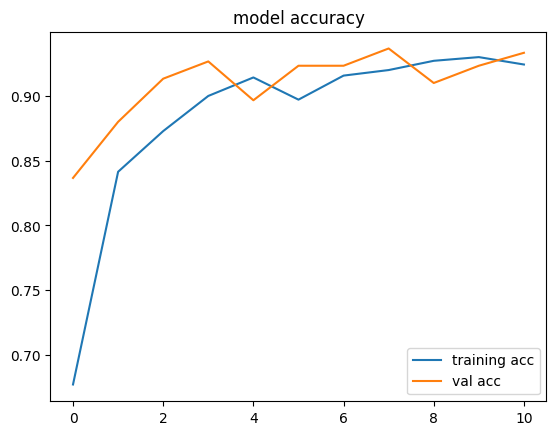

In [5]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='training acc')
plt.plot(history.history['val_accuracy'],label='val acc')
plt.title('model accuracy')
plt.xlabel=('epochs')
plt.ylabel=('acc')
plt.legend()
plt.show()


## 🧠 Step 6: Plotting Training and Validation Loss

### ⚡ Visualizing Model Loss
In addition to accuracy, monitoring **loss over epochs** helps understand how well the model is learning.  
We plot both **training loss** and **validation loss** to detect underfitting or overfitting.

**Code:**
```python
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


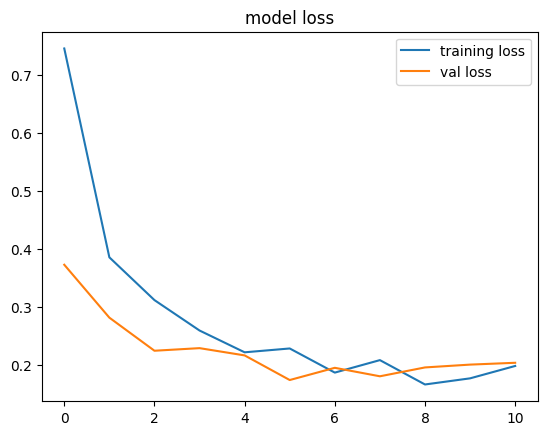

In [6]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.title('model loss')
plt.xlabel=('epochs')
plt.ylabel=('loss')
plt.legend()
plt.show()


## 🧩 Step 7: Visualizing Augmented Training Images

### ⚡ Why Visualize?
Before training, it’s important to **inspect the augmented images** to ensure that all transformations are being applied correctly.  
This step helps verify that the model will see a diverse set of images during training.

### 🧠 How It Works
- A batch of images is fetched from the training generator, which contains all the augmentations (rotation, flip, zoom, etc.).  
- The first few images in the batch are displayed in a grid for easy inspection.  
- The class labels for each image are shown to confirm that the data is labeled correctly.  
- Since images are already normalized (scaled between 0 and 1), they are displayed exactly as the model sees them.

### ✅ Summary
- This step ensures that **data augmentation is applied properly**.  
- Visualizing augmented images helps catch preprocessing errors early.  
- It also gives insight into the kind of variations the model will learn to handle, improving its robustness and generalization.


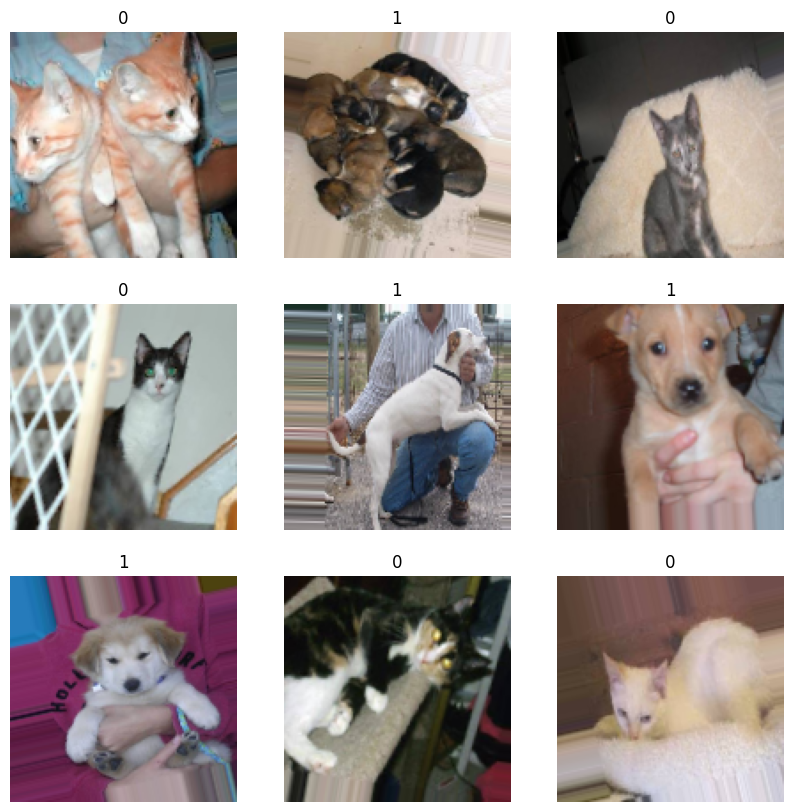

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels
images, labels = next(train_datagen)

# Plot first 9 images in the batch
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])  # images are already scaled to 0-1 because of rescale
    plt.title(np.argmax(labels[i]))  # show the class index
    plt.axis('off')
plt.show()


## 🧩 Step 8: Saving the Trained Model

### ⚡ Why Save the Model?
After training, it’s important to **save the model** so that you can:
- Use it later for inference without retraining.
- Share it with others or deploy it in applications.
- Resume training if needed.

### 🧠 How It Works
- The trained CNN model, including all layers, weights, and configurations, is saved to a file (in this case, `cat_vs_dog.keras`).  
- This saved model can be **loaded later** using TensorFlow/Keras for prediction or further training.

### ✅ Summary
- Saving the model ensures that your work is **reproducible and portable**.  
- It allows you to **deploy the model** in applications, notebooks, or cloud services without retraining.


In [8]:
model.save("cat_vs_dog.keras")
